# Masking the Data
Placing a limit on the frequency may help you achieve an optimal result in the fitting process.

Even on a good dataset, we can get a sizable error if we take into consideration every single frequency of data. This is because there can be some data that is considered an outlier. Take for example, 'DE_40_1_30.mpt' which by all accounts, is a good dataset without any unusual spikes or drops in the data. Let's take a look at if we were to import all frequencies in the file.

In [1]:
#Locate the data, prepare for import of the MPT file
#Import necessary packaging
from utils.tools import *
path=r"C:\Users\cjang\Desktop\Kyler_Speed_Circuit-development\data\\"
data = ['DE_40_14_60.mpt']
ex_mpt = mpt_data(path,data)

No handles with labels found to put in legend.


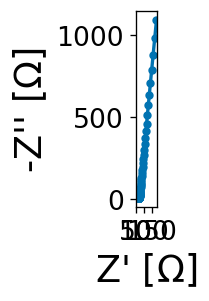

In [2]:
ex_mpt.mpt_plot()

If we take the guessing iterator and run it on this dataset, the guessing iterator has to find a fitting equation that satisfies every single point on this set, or something that is close.

Because the iterator cut out at 1000 iterations and return the set of coefficients at that state, we cannot say with full confidence that this is the best fit because it didn't necessarily satisfy the threshold. If we graph this 'optimal' set of coefficients, we aren't guaranteed a great fitting graph...

What we can do is eliminate some of the frequencies from the file to make it easier to get a more accurate graph. But how do we determine which frequencies to drop from the file? 

# Linear Kramer Kronig Analysis

The Linear Kramer Kronig Analysis determines the causality, linearity, and stability of the dataset. It'll help you determine a mask by examining the residual graph. Running the function ex_mpt.LinKK() will allow you to see where your residuals are fluctuating the most. From here you can determine on your own what your boundaries should be.

cycle || No. RC-elements ||   u
[1]            8            0.84


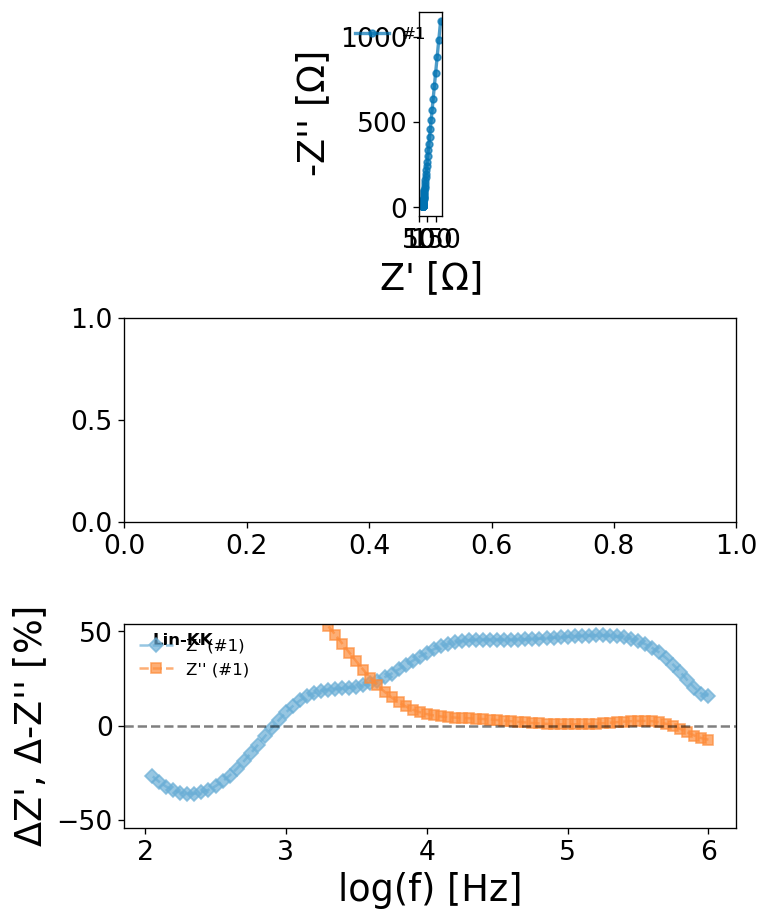

In [3]:
#Will be updated
ex_mpt.Lin_KK(plot = 'w_data')

In [4]:
#Notice how the graph shows log(f) not f. We must translate back
#so instead of 1.75 and 6, we must insert 10**1.75 and 10**6
masked_mpt = mpt_data(path,data, mask = [10**5.5, 10**4])
#masked_mpt.guesser(Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2)

No handles with labels found to put in legend.


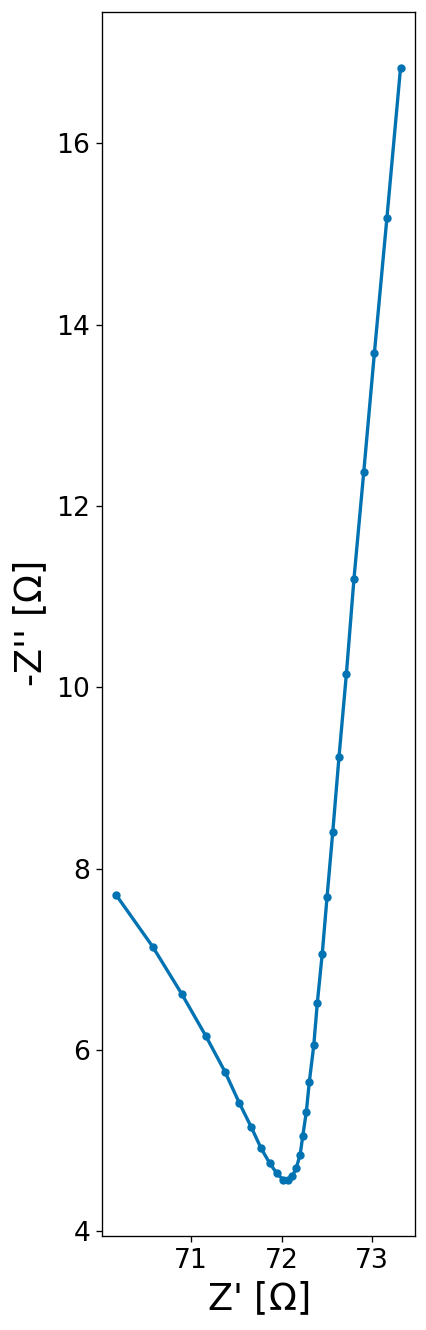

In [5]:
masked_mpt.set_new_gph_dims(20,30)
masked_mpt.mpt_plot()

# Automated Masker

The process above is ideal if all your fitting is a single mpt file. If we want to fit multiple files, or hundreds of files in a batch folder, we need a more automated process. We can call on ex_mpt.masker() to find the best window for us. 

Calling masker takes the average of the distance between the residuals and uses it as an additional threshold, so if the residual lands outside the threshold, all frequencies associated with that residual point will be omitted from the graph. We then run the guessing iterator and see if it achieves 1e-10 error within a thousand iterations. If it does not, we shrink the threshold by a factor of 0.9 to increase exclusivity. 


In [1]:
low_error = 0
def leastsq_errorfunc(params, w, re, im, circuit, weight_func):
    if circuit == 'R-RQ-RQ':
        re_fit = cir_RsRQRQ_fit(params, w).real
        im_fit = -cir_RsRQRQ_fit(params, w).imag
    else:
        print('Circuit is not defined in leastsq_errorfunc()')
    
    error = [(re-re_fit)**2, (im-im_fit)**2] #sum of squares
    print('ERROR: ', sum(error))
    #Different Weighing options, see Lasia
    if weight_func == 'modulus':
        weight = [1/((re_fit**2 + im_fit**2)**(1/2)), 1/((re_fit**2 + im_fit**2)**(1/2))]
    elif weight_func == 'proportional':
        weight = [1/(re_fit**2), 1/(im_fit**2)]
    elif weight_func == 'unity':
        unity_1s = []
        for k in range(len(re)):
            unity_1s.append(1) #makes an array of [1]'s, so that the weighing is == 1 * sum of squres.
        weight = [unity_1s, unity_1s]
    else:
        print('weight not defined in leastsq_errorfunc()')
        
    S = np.array(weight) * error #weighted sum of squares
    print('Weighted SUM OF SQUARES: ',sum(S)) 
    return sum(S)

No handles with labels found to put in legend.
153670.13264925755
153670.13264925755
153670.13264925755
153670.03341284936
153670.13262580096
153670.13264926235
153670.13264925755
153670.13264668404
153670.13264925824
153670.13264452384
14225952798843.693
45979874676940.61
66023681899.03675
30558895029266.195
7990164044.335512
104608.00405997797
104607.92163449133
104607.75062018252
104608.00411578374
104607.92114878316
104607.99919584274
104608.00171512853
104607.99589533951
96749.21465637597
96749.1355693077
96748.95100379418
96749.21475034553
96749.21576804535
96749.20892526573
96749.21138954969
96749.20517952493
82525.07795630109
82525.00832418202
82524.8278990396
82525.0778917413
82525.07776149477
82525.07749248798
82525.07367426276
82525.07524325342
66527.33014956585
66527.27702448149
66527.14382896305
66527.33015012887
66527.33083255411
66527.34291627894
66527.32853393188
66527.34202427913
58594.4250582941
58594.37989026789
58594.2503794085
58594.42506959412
58594.4162583729
585

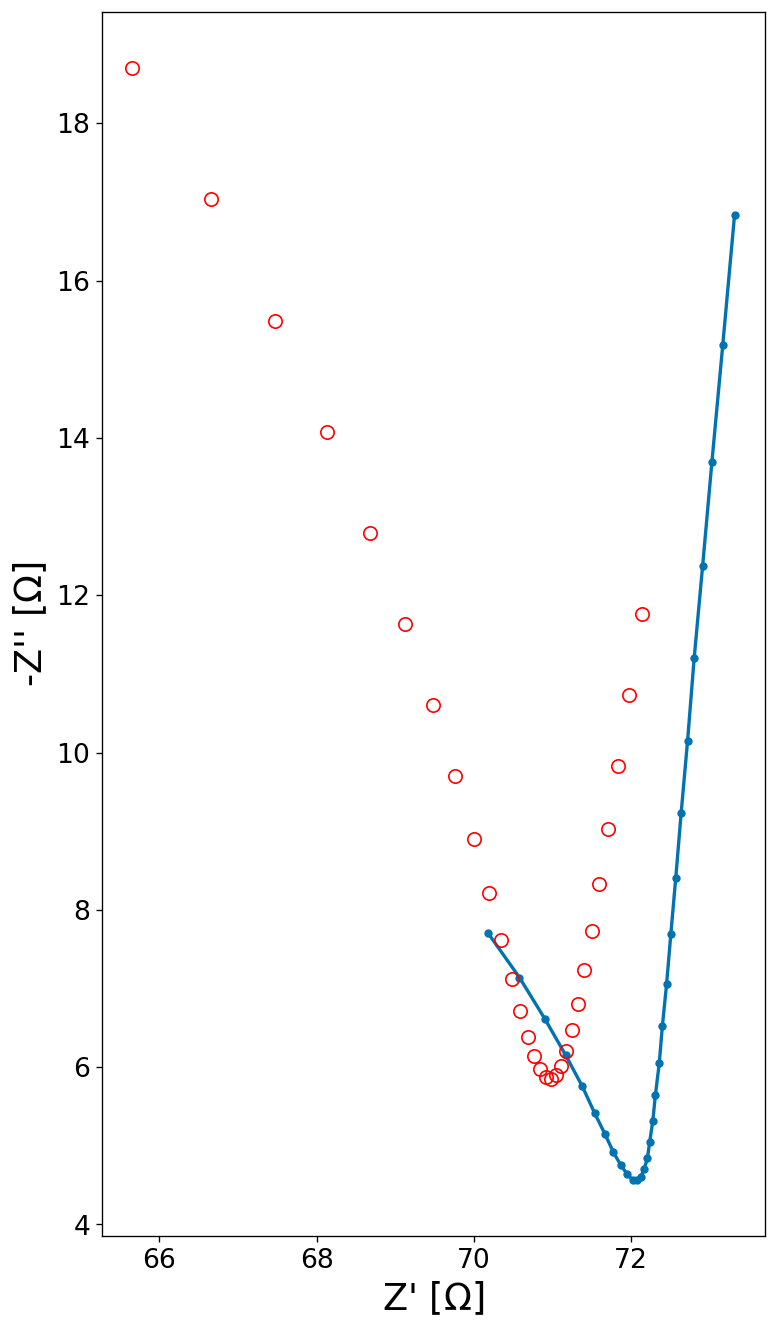

In [7]:
params = Parameters()
Rs_guess = 1

R_guess = 1
n_guess = 0.8
fs_guess = 1

R2_guess = 1
n2_guess = 0.8
fs2_guess = 0.2        
guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
#adding to the parameters package to send to the fitting function
params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=10**6)
params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=10**6)
params.add('n', value=guess_package[2], min=.65, max=1)
params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=10**6)
params.add('n2', value=guess_package[5], min=.65, max=1)
params.add('fs2', value=guess_package[6], min=10**-2, max=10**6)
masked_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')
masked_mpt.mpt_plot(fitting = 'on')

No handles with labels found to put in legend.
[55.278562538774686, 15.57164662465339, 1.2, 539961.7707767643, 7246.510978744702, 0.8800836155301477, 10.0]
5.042811380706266
5.042811380706266
5.042811380706266
5.042734916501388
5.042806768348111
5.042811380706265
5.042811386032457
5.042808975315746
5.042811650950785
5.042811380706276
203.15373623338897
9.349272080762624
926.2280398168389
521.579866237339
1026.6460891447953
5.042811380706266
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 60
    # variables        = 7
    chi-square         = 1.6625e-04
    reduced chi-square = 3.1368e-06
    Akaike info crit   = -753.782519
    Bayesian info crit = -739.122107
[[Variables]]
    Rs:   55.2785625 +/- 0.85750489 (1.55%) (init = 55.27856)
    R:    15.5716466 +/- 0.82529415 (5.30%) (init = 15.57165)
    n:    1.20000000 +/- 3.6601e-12 (0.00%) (init = 1.2)
    fs:   539961.771 +/- 25480.5599 (4.72%) (init = 539961.8)
    R2:   7246.51

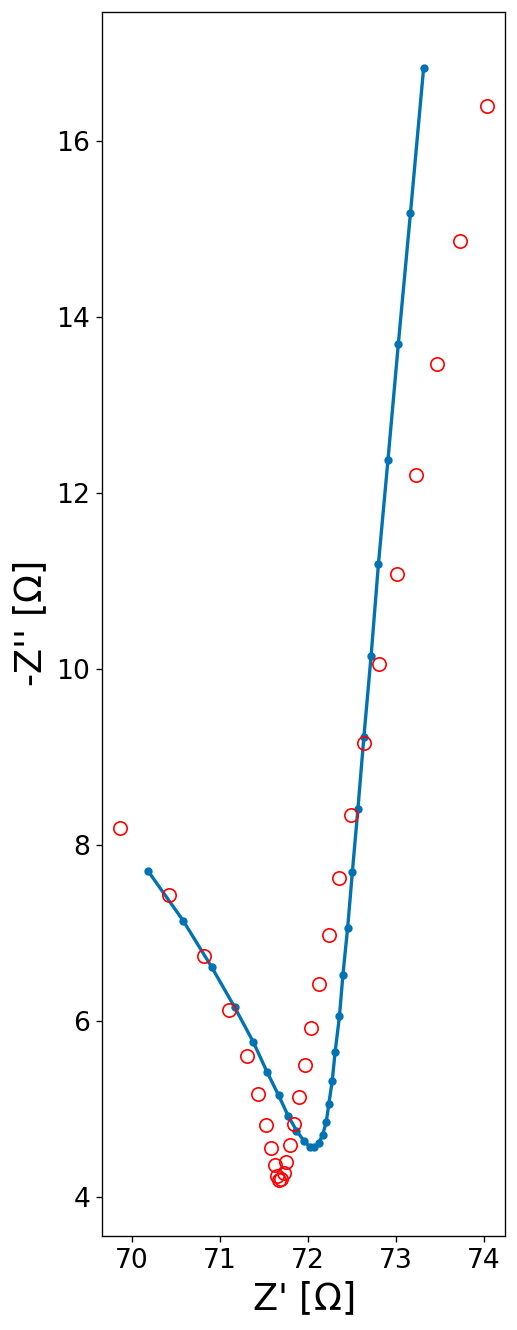

In [10]:
tyn = [masked_mpt.fit_Rs[0],masked_mpt.fit_R[0],masked_mpt.fit_n[0],masked_mpt.fit_fs[0],masked_mpt.fit_R2[0],masked_mpt.fit_n2[0],masked_mpt.fit_fs2[0]]
print(tyn)
Rs_guess = tyn[0]

R_guess = tyn[1]
n_guess = tyn[2]
fs_guess = tyn[3]

R2_guess = tyn[4]
n2_guess = tyn[5]
fs2_guess = tyn[6]     

guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
#adding to the parameters package to send to the fitting function
params = Parameters()
params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=guess_package[0]*100)
params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=guess_package[1]*10)
params.add('n', value=guess_package[2], min=.65, max=1.2)
params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=guess_package[4]*10)
params.add('n2', value=guess_package[5], min=.65, max=1.2)
params.add('fs2', value=guess_package[6], min=10**-2, max=10**1)
masked_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')
masked_mpt.mpt_plot(fitting = 'on')

No handles with labels found to put in legend.
0.23486209194760913
0.23486209194760913
0.23486209194760913
0.23486392619373636
0.23486232443692934
0.23486208865466668
0.23486209192302887
0.23486204731765378
0.23486209140126146
0.23486209194760965
382.2949414166656
1306.7929944261314
797.5253625167833
642.3194406487962
906.521388455121
1215.6136873928842
0.23486209194760913
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 60
    # variables        = 7
    chi-square         = 2.8057e-07
    reduced chi-square = 5.2938e-09
    Akaike info crit   = -1136.84712
    Bayesian info crit = -1122.18671
[[Variables]]
    Rs:   44.7806119 +/- 0.89943742 (2.01%) (init = 44.78061)
    R:    27.2427644 +/- 0.91239593 (3.35%) (init = 27.24276)
    n:    1.00247242 +/- 0.00649775 (0.65%) (init = 1.002472)
    fs:   999998.898 +/- 41102.8806 (4.11%) (init = 999998.9)
    R2:   11835.6470 +/- 168.983016 (1.43%) (init = 11835.65)
    n2:   0.9498597

[44.780611904214744]

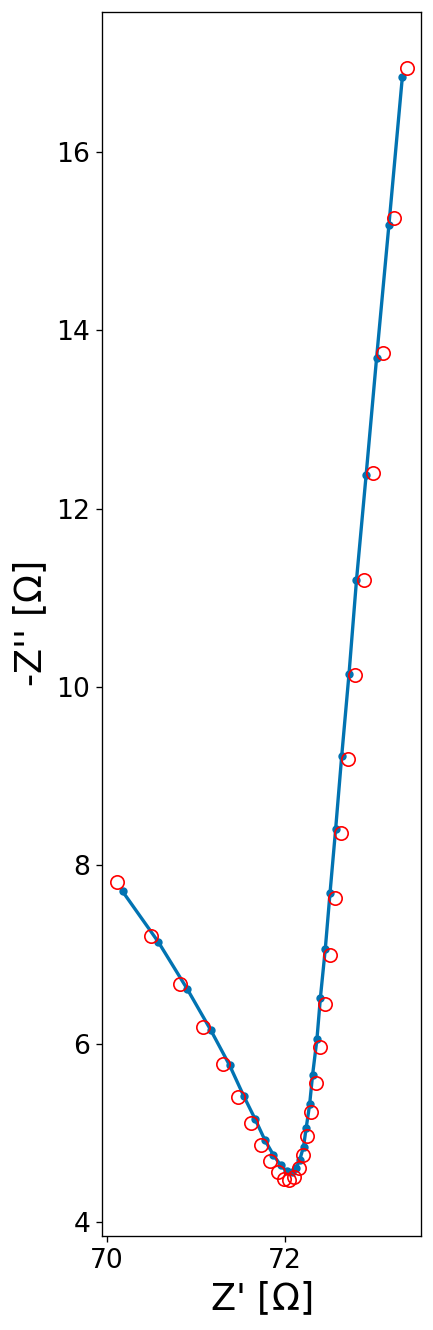

In [16]:
tyn = [masked_mpt.fit_Rs[0],masked_mpt.fit_R[0],masked_mpt.fit_n[0],masked_mpt.fit_fs[0],masked_mpt.fit_R2[0],masked_mpt.fit_n2[0],masked_mpt.fit_fs2[0]]
Rs_guess = tyn[0]

R_guess = tyn[1]
n_guess = tyn[2]
fs_guess = tyn[3]

R2_guess = tyn[4]
n2_guess = tyn[5]
fs2_guess = tyn[6]     

guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
#adding to the parameters package to send to the fitting function
params2 = Parameters()
params2.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=guess_package[0]*100)
params2.add('R', value=guess_package[1], min=guess_package[1]*.1, max=guess_package[1]*10)
params2.add('n', value=guess_package[2], min=.65, max=1.2)
params2.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
params2.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=guess_package[4]*10)
params2.add('n2', value=guess_package[5], min=.65, max=1.2)
params2.add('fs2', value=guess_package[6], min=10**-2, max=10**1)
masked_mpt.mpt_fit(params2, circuit = 'R-RQ-RQ')
masked_mpt.mpt_plot(fitting = 'on')
masked_mpt.fit_Rs

No handles with labels found to put in legend.
5.042811380704514
5.042811380704514
5.042811380704514
5.042734916499696
5.042806768346374
5.042811380704526
5.042811386030711
5.042808975313962
5.042811650949026
5.042811380704514
3.4250115245059622
3.424987328107275
3.425009952951234
3.4244572428640296
3.4250115259481926
3.425009406283964
3.425011653805929
3.4250115245059813
240.46243064968573
3.8917248793325907
2.8743293529995664
2.8742962833190613
2.874327335784833
2.874180339441016
2.8743293530122376
2.8743282951169475
2.874329415952473
2.874329352999577
2.777801159123162
2.7777728220447258
2.7777992891350665
2.7775302618387827
2.7778011595349765
2.777801338483283
2.7778011450769498
2.7778011591231757
2.678612409481922
2.67858520894817
2.67861066726385
2.6783456532121512
2.678612409665942
2.6786129834655883
2.6786123763543688
2.678612409481923
2.264110535763191
2.2640976794858845
2.264109588831407
2.263593491337076
2.264110536025745
2.26411094065418
2.264110518856638
2.2641105357631814

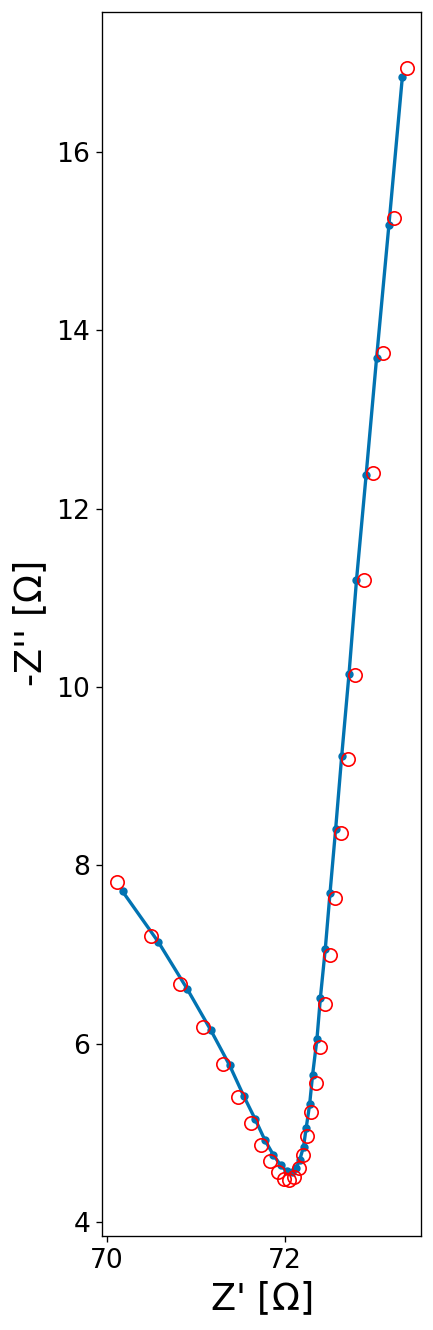

In [15]:
tyn = [masked_mpt.fit_Rs[0],masked_mpt.fit_R[0],masked_mpt.fit_n[0],masked_mpt.fit_fs[0],masked_mpt.fit_R2[0],masked_mpt.fit_n2[0],masked_mpt.fit_fs2[0]]
Rs_guess = tyn[0]

R_guess = tyn[1]
n_guess = tyn[2]
fs_guess = tyn[3]

R2_guess = tyn[4]
n2_guess = tyn[5]
fs2_guess = tyn[6]     

guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
#adding to the parameters package to send to the fitting function
params2 = Parameters()
params2.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=guess_package[0]*100)
params2.add('R', value=guess_package[1], min=guess_package[1]*.1, max=guess_package[1]*10)
params2.add('n', value=guess_package[2], min=.65, max=1.2)
params2.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
params2.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=guess_package[4]*10)
params2.add('n2', value=guess_package[5], min=.65, max=1.2)
params2.add('fs2', value=guess_package[6], min=10**-2, max=10**1)
masked_mpt.mpt_fit(params2, circuit = 'R-RQ-RQ')
masked_mpt.mpt_plot(fitting = 'on')

In [16]:
counter = 0
def guesser(ex_mpt, Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2):
    counter += 1
    guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
    
    
    #adding to the parameters package to send to the fitting function
    params = Parameters()
    params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=10**6)
    params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=10**6)
    params.add('n', value=guess_package[2], min=.65, max=1)
    params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
    params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=10**6)
    params.add('n2', value=guess_package[5], min=.65, max=1)
    params.add('fs2', value=guess_package[6], min=10**-2, max=10**6)
    ex_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')
    ex_mpt.mpt_plot(fitting = 'on')

    if low_error <= 2.0:
        print(low_error)
        tyn = [ex_mpt.fit_Rs[0],ex_mpt.fit_R[0],ex_mpt.fit_n[0],ex_mpt.fit_fs[0],ex_mpt.fit_R2[0],ex_mpt.fit_n2[0],ex_mpt.fit_fs2[0]]
        Rs_guess = tyn[0]

        R_guess = tyn[1]
        n_guess = tyn[2]
        fs_guess = tyn[3]

        R2_guess = tyn[4]
        n2_guess = tyn[5]
        fs2_guess = tyn[6]     

        guesser(ex_mpt, tyn[0], tyn[1], tyn[2], tyn[3], tyn[4], tyn[5], tyn[6])
    
    print(low_error)
    ex_mpt.


Note that there are varying amounts of iteration for convergence, you may take longer to achieve threshold

In [8]:
def masker(ex_mpt, number):
    num_RC='auto' 
    legend='on'
    plot='residuals'
    bode='off'
    nyq_xlim='none'
    nyq_ylim='none'
    weight_func='Boukamp'



    print('cycle || No. RC-elements ||   u')
    ex_mpt.decade = []
    ex_mpt.Rparam = []
    ex_mpt.t_const = []
    ex_mpt.Lin_KK_Fit = []
    ex_mpt.R_names = []
    ex_mpt.KK_R0 = []
    ex_mpt.KK_R = []
    ex_mpt.number_RC = []
    ex_mpt.number_RC_sort = []

    ex_mpt.KK_u = []
    ex_mpt.KK_Rgreater = []
    ex_mpt.KK_Rminor = []
    M = 2
    for i in range(len(ex_mpt.df)):
        ex_mpt.decade.append(np.log10(np.max(ex_mpt.df[i].f))-np.log10(np.min(ex_mpt.df[i].f))) #determine the number of RC circuits based on the number of decades measured and num_RC
        ex_mpt.number_RC.append(M)
        ex_mpt.number_RC_sort.append(M) #needed for ex_mpt.KK_R
        ex_mpt.Rparam.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0]) #Creates intial guesses for R's
        ex_mpt.t_const.append(KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i]))) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits
        
        ex_mpt.Lin_KK_Fit.append(minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) )) #maxfev=99
        ex_mpt.R_names.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1]) #creates R names
        for j in range(len(ex_mpt.R_names[i])):
            ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[i].params.get(ex_mpt.R_names[i][j]).value)
    ex_mpt.number_RC_sort.insert(0,0) #needed for ex_mpt.KK_R
    for i in range(len(ex_mpt.df)):
        ex_mpt.KK_R.append(ex_mpt.KK_R0[int(np.cumsum(ex_mpt.number_RC_sort)[i]):int(np.cumsum(ex_mpt.number_RC_sort)[i+1])]) #assigns resistances from each spectra to their respective df
        ex_mpt.KK_Rgreater.append(np.where(np.array(ex_mpt.KK_R)[i] >= 0, np.array(ex_mpt.KK_R)[i], 0) )
        ex_mpt.KK_Rminor.append(np.where(np.array(ex_mpt.KK_R)[i] < 0, np.array(ex_mpt.KK_R)[i], 0) )
        ex_mpt.KK_u.append(1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i]))))

    for i in range(len(ex_mpt.df)):
        while ex_mpt.KK_u[i] <= 0.75 or ex_mpt.KK_u[i] >= 0.88:
            ex_mpt.number_RC_sort0 = []
            ex_mpt.KK_R_lim = []
            ex_mpt.number_RC[i] = ex_mpt.number_RC[i] + 1
            ex_mpt.number_RC_sort0.append(ex_mpt.number_RC)
            ex_mpt.number_RC_sort = np.insert(ex_mpt.number_RC_sort0, 0,0)
            ex_mpt.Rparam[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0] #Creates intial guesses for R's
            ex_mpt.t_const[i] = KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i])) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits
            ex_mpt.Lin_KK_Fit[i] = minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) ) #maxfev=99
            ex_mpt.R_names[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1] #creates R names
            ex_mpt.KK_R0 = np.delete(np.array(ex_mpt.KK_R0), np.s_[0:len(ex_mpt.KK_R0)])
            ex_mpt.KK_R0 = []
            for q in range(len(ex_mpt.df)):
                for j in range(len(ex_mpt.R_names[q])):
                    ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[q].params.get(ex_mpt.R_names[q][j]).value)
            ex_mpt.KK_R_lim = np.cumsum(ex_mpt.number_RC_sort) #used for KK_R[i]

            ex_mpt.KK_R[i] = ex_mpt.KK_R0[ex_mpt.KK_R_lim[i]:ex_mpt.KK_R_lim[i+1]] #assigns resistances from each spectra to their respective df
            ex_mpt.KK_Rgreater[i] = np.where(np.array(ex_mpt.KK_R[i]) >= 0, np.array(ex_mpt.KK_R[i]), 0)
            ex_mpt.KK_Rminor[i] = np.where(np.array(ex_mpt.KK_R[i]) < 0, np.array(ex_mpt.KK_R[i]), 0)
            ex_mpt.KK_u[i] = 1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i])))
        else:
            print('['+str(i+1)+']'+'            '+str(ex_mpt.number_RC[i]),'           '+str(np.round(ex_mpt.KK_u[i],2)))

    ex_mpt.KK_circuit_fit = []
    ex_mpt.KK_rr_re = []
    ex_mpt.KK_rr_im = []
    functs = []
    for i in range(2,81):
        functs.append('KK_RC'+str(i))

    for i in range(len(ex_mpt.df)):
        cir_num = int(ex_mpt.number_RC[i])
        cir_funct = eval(functs[cir_num - 2])
        ex_mpt.KK_circuit_fit.append(cir_funct(w=ex_mpt.df[0].w, Rs=ex_mpt.Lin_KK_Fit[0].params.get('Rs').value, R_values=ex_mpt.KK_R[0], t_values=ex_mpt.t_const[0]))
        if cir_num >= 81:
            print('RC simulation circuit not defined')
            print('   Number of RC = ', ex_mpt.number_RC)
        ex_mpt.KK_rr_re.append(residual_real(re=ex_mpt.df[i].re, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the real part
        ex_mpt.KK_rr_im.append(residual_imag(im=ex_mpt.df[i].im, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the imag part

        ex_mpt.kk_df = pd.DataFrame({'f':np.log10(ex_mpt.df_raw.f), 're':ex_mpt.KK_rr_re[0]*100, 'im':ex_mpt.KK_rr_im[0]*100})
        ex_mpt.kk_df['difference'] = abs(ex_mpt.kk_df['re'] - ex_mpt.kk_df['im'])
        diff_mean = ex_mpt.kk_df['difference'].mean()
        masked_df = ex_mpt.kk_df[ex_mpt.kk_df['difference'] < diff_mean * number]
        print('MASK BOUNDARIES: ', 10**masked_df['f'].max(),10**masked_df['f'].min())
        masked_mpt = mpt_data(ex_mpt.path, ex_mpt.data, mask = [10**masked_df['f'].max(),10**masked_df['f'].min()])
        
        curr_error = leastsq_errorfunc(params)
        if leastsq:
            return masker(ex_mpt, number * .9)
        return (10**masked_df['f'].max(),10**masked_df['f'].min())